In [1]:
!nvidia-smi

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow: {tf.__version__}")
print(f"GPUs: {gpus}")

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU ENABLED!")
else:
    print("❌ NO GPU! Go to Runtime → Change runtime type → GPU")


Thu Feb  5 15:25:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
import pickle
import json
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

print("✅ Libraries imported!")


✅ Libraries imported!


In [3]:
from google.colab import drive
drive.mount('/content/drive')
print("✅ Drive mounted!")


Mounted at /content/drive
✅ Drive mounted!


In [4]:
import os

DATASET_PATH = '/content/drive/MyDrive/CaptoneProject/camera'
ZIP_PATH = '/content/drive/MyDrive/CaptoneProject/camera.zip'

if os.path.exists(ZIP_PATH):
    print(f"✅ ZIP found at {ZIP_PATH}")
else:
    print("⚠️ ZIP not found! Please run the specific zip creation cell if needed.")


✅ ZIP found at /content/drive/MyDrive/CaptoneProject/camera.zip


In [5]:
import os
import shutil

ZIP_PATH = '/content/drive/MyDrive/CaptoneProject/camera.zip'
LOCAL_PATH = '/content/dataset'

if not os.path.exists(LOCAL_PATH):
    if os.path.exists(ZIP_PATH):
        print("📦 Unzipping... (this might take a moment)")
        !unzip -q -o "{ZIP_PATH}" -d /content/

        # Handle directory structure
        if os.path.exists('/content/camera'):
            !mv /content/camera "{LOCAL_PATH}"
        elif os.path.exists('/content/train') and os.path.exists('/content/test'):
            os.makedirs(LOCAL_PATH, exist_ok=True)
            !mv /content/train "{LOCAL_PATH}/train"
            !mv /content/test "{LOCAL_PATH}/test"
        print("✅ Dataset ready at /content/dataset")
    else:
        print("❌ ZIP file not found in Drive!")
else:
    print("✅ Dataset already exists locally!")

TRAIN_DIR = os.path.join(LOCAL_PATH, 'train')
TEST_DIR = os.path.join(LOCAL_PATH, 'test')


📦 Unzipping... (this might take a moment)
✅ Dataset ready at /content/dataset


In [6]:
# ========================================
# CONFIG: METHOD 3 - MOBILENETV2 (RGB)
# ========================================
IMG_SIZE = 48
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.0001 # Lower LR for Fine-tuning
NUM_CLASSES = 7
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

CHECKPOINT_DIR = '/content/drive/MyDrive/CaptoneProject/checkpoints/method3_mobilenet'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
MODEL_CHECKPOINT_PATH = f'{CHECKPOINT_DIR}/checkpoint.keras'
BEST_MODEL_PATH = f'{CHECKPOINT_DIR}/best_model.keras'
HISTORY_PATH = f'{CHECKPOINT_DIR}/history.pkl'


In [7]:
# RGB COLOR MODE FOR TRANSFER LEARNING
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, brightness_range=[0.8, 1.2], fill_mode='nearest', validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(48,48), color_mode='rgb', batch_size=BATCH_SIZE, class_mode='categorical', subset='training', seed=SEED)
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(48,48), color_mode='rgb', batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', seed=SEED)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(48,48), color_mode='rgb', batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
train_labels = train_generator.classes
class_weights_array = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights_array))

print("📊 Class Weights calculated!")


📊 Class Weights calculated!


In [9]:
def build_mobilenet(input_shape=(48, 48, 3), num_classes=7):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', alpha=0.35)

    # Fine-tine: Freeze early layers, unfreeze late
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = build_mobilenet()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
model.summary()


2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.35_224            │ (None, 2, 2, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 773,479 (2.95 MB)

 Trainable params: 653,799 (2.49 MB)

 Non-trainable params: 119,680 (467.50 KB)

In [10]:
class SaveHistoryCallback(keras.callbacks.Callback):
    def __init__(self, history_path, checkpoint_path):
        super().__init__()
        self.history_path = history_path
        self.checkpoint_path = checkpoint_path
        self.history_data = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': [], 'lr': []}

    def on_epoch_end(self, epoch, logs=None):
        self.history_data['accuracy'].append(logs.get('accuracy'))
        self.history_data['val_accuracy'].append(logs.get('val_accuracy'))
        self.history_data['loss'].append(logs.get('loss'))
        self.history_data['val_loss'].append(logs.get('val_loss'))
        self.history_data['lr'].append(float(self.model.optimizer.learning_rate.numpy()))

        with open(self.history_path, 'wb') as f:
            pickle.dump(self.history_data, f)
        # Save checkpoint periodically or on best is handled by ModelCheckpoint,
        # but we can save here too if needed.
        # self.model.save(self.checkpoint_path)

callbacks = [
    ModelCheckpoint(filepath=BEST_MODEL_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
    SaveHistoryCallback(HISTORY_PATH, MODEL_CHECKPOINT_PATH)
]
print("✅ Callbacks configured!")


✅ Callbacks configured!


In [11]:
print("🚀 Starting Training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)
print("✅ Training Completed!")


🚀 Starting Training...
Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.1630 - loss: 3.0996
Epoch 1: val_accuracy improved from -inf to 0.12977, saving model to /content/drive/MyDrive/CaptoneProject/checkpoints/method3_mobilenet/best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 97s 197ms/step - accuracy: 0.1630 - loss: 3.0994 - val_accuracy: 0.1298 - val_loss: 2.5724 - learning_rate: 1.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1760 - loss: 2.8482
Epoch 2: val_accuracy improved from 0.12977 to 0.15886, saving model to /content/drive/MyDrive/CaptoneProject/checkpoints/method3_mobilenet/best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 43s 118ms/step - accuracy: 0.1760 - loss: 2.8481 - val_accuracy: 0.1589 - val_loss: 2.5271 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1783 - loss: 2.7472
Epoch 3: val_accuracy improved from 0.15886 to 0.19753, saving model to /content/drive/MyDrive/CaptoneProjec

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.3039 - loss: 1.8525

🎯 TEST ACCURACY: 36.28%
   TEST LOSS: 1.7924
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step
              precision    recall  f1-score   support

       angry     0.3274    0.3048    0.3157       958
     disgust     0.0741    0.4955    0.1290       111
        fear     0.2926    0.0654    0.1069      1024
       happy     0.4731    0.4752    0.4741      1774
     neutral     0.3389    0.3933    0.3641      1233
         sad     0.4025    0.2085    0.2747      1247
    surprise     0.4135    0.7244    0.5265       831

    accuracy                         0.3628      7178
   macro avg     0.3317    0.3810    0.3130      7178
weighted avg     0.3795    0.3628    0.3478      7178



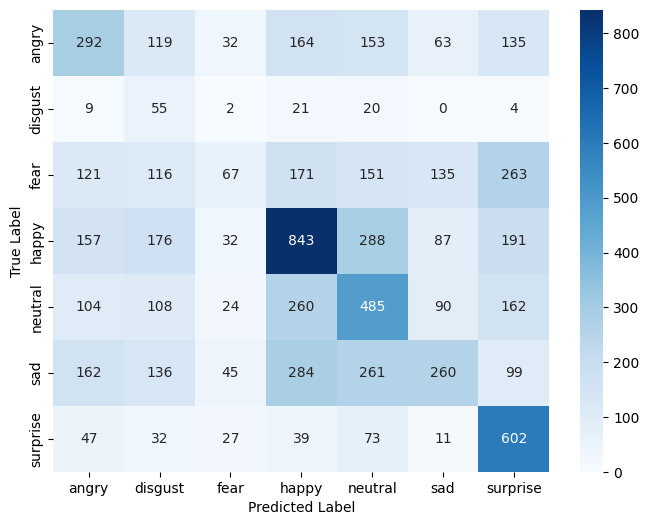

In [12]:
# Load best model
best_model = keras.models.load_model(BEST_MODEL_PATH)

test_generator.reset()
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"\n🎯 TEST ACCURACY: {test_acc*100:.2f}%")
print(f"   TEST LOSS: {test_loss:.4f}")

# Predictions
predictions = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=EMOTIONS, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

